# pyNetworkPlot

In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from polyleven import levenshtein as poly_lev
#from collections import defaultdict
import igraph as ig
import random # layout seed
import cairo as cr
from igraph.drawing.text import TextDrawer
from math import pi # Legend circles
from PIL.ImageColor import getcolor

In [2]:
module_path = os.path.abspath(os.path.join('..', 'bin'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# from ../bin
import spring_functions as kxs
from data_functions import group_with_freq
from drawing import *

## Parameters

In [4]:
pd.set_option('display.max_columns',None)

#### Data parameters

out_file = '../results/N_glyc_all_Full_sim8.pdf'
seq_col = 'Full_VH_VL'#Full_VH_VL or VDJ_REGION_AA_sequence_of_H
color_col = 'Patient'
custom_color = None#'../data/custom_colors.txt'
shape_col = 'Any_N_glyc'#'receptor_revision'
size_col = None
#min_seq2show = 0 # integer
group_unique = True # Boolean

In [5]:
out_file = '../results/P274_Full_sim8.pdf'
seq_col = 'Full_VH_VL'#Full_VH_VL or VDJ_REGION_AA_sequence_of_H
color_col = 'lineage'
custom_color = None#'../data/custom_colors.txt'
shape_col = 'receptor_revision'#'receptor_revision'
size_col = None
#min_seq2show = 0 # integer
group_unique = True # Boolean

#### Figure parameters

In [6]:
# Similarity threshold
similarity = 8 # non-negative integer
max_node_size=50
min_node_size=5
layout_name = 'FR' # Can be FR, DH, DrL, GO, LgL, MDS
legend = True
unit=100
edge_width = 1.5

In [7]:
in_file = '../data/P274.xlsx'
#in_file = '../data/P268.xlsx'
file_type = in_file.split('.')[-1]
if file_type == 'tsv':
    DF = pd.read_csv(in_file,sep='\t',index_col=0).reset_index(drop=True)
elif file_type == 'xlsx':
    DF = pd.read_excel(in_file,index_col=0)
elif file_type == 'csv':
    DF = pd.read_csv(in_file,sep=',',index_col=0).reset_index(drop=True)
else:
    raise NameError("Invalid input format. Has to be either .tsv, .csv or .xlsx.")

In [8]:
DF

,receptor_revision,lineage,VDJ_REGION_AA_sequence_of_H,Full_VH_VL
0,yes,274-1,EVQLVESGGGLVQPGGSLRLSCAASGFSFTNHAMSWVRQAPGKGLE...,EVQLVESGGGLVQPGGSLRLSCAASGFSFTNHAMSWVRQAPGKGLE...
1,yes,274-1,EVQLVESGGGLVQPGGSLRLSCAASGFSFTNHAMSWVRQAPGKGLE...,EVQLVESGGGLVQPGGSLRLSCAASGFSFTNHAMSWVRQAPGKGLE...
2,yes,274-2,EVQLVESGGGLVQPGGSLRLSCVASGFTFNDHWMTWVRQAPGKGLE...,EVQLVESGGGLVQPGGSLRLSCVASGFTFNDHWMTWVRQAPGKGLE...
3,yes,274-2,EVQLVESGGGLVQPGGSLRLSCVASGFTFNDHWMTWVRQAPGKGLE...,EVQLVESGGGLVQPGGSLRLSCVASGFTFNDHWMTWVRQAPGKGLE...
4,yes,274-3,QVQLVQSGPDLREPGSSVKVSCQAPSDLFSSHSFSWVRQAPGQGLE...,QVQLVQSGPDLREPGSSVKVSCQAPSDLFSSHSFSWVRQAPGQGLE...
5,yes,274-3,EVQLVQSGPGLRAPGSSVKVSCQAPSDLFSSHSFSWVRQAPGQGLE...,EVQLVQSGPGLRAPGSSVKVSCQAPSDLFSSHSFSWVRQAPGQGLE...


In [9]:
new_columns = bool(seq_col)*[seq_col]+bool(color_col)*[color_col]+bool(shape_col)*[shape_col]+\
bool(size_col)*[size_col]
new_columns
DF = DF.loc[:,new_columns]
DF

,Full_VH_VL,lineage,receptor_revision
0,EVQLVESGGGLVQPGGSLRLSCAASGFSFTNHAMSWVRQAPGKGLE...,274-1,yes
1,EVQLVESGGGLVQPGGSLRLSCAASGFSFTNHAMSWVRQAPGKGLE...,274-1,yes
2,EVQLVESGGGLVQPGGSLRLSCVASGFTFNDHWMTWVRQAPGKGLE...,274-2,yes
3,EVQLVESGGGLVQPGGSLRLSCVASGFTFNDHWMTWVRQAPGKGLE...,274-2,yes
4,QVQLVQSGPDLREPGSSVKVSCQAPSDLFSSHSFSWVRQAPGQGLE...,274-3,yes
5,EVQLVQSGPGLRAPGSSVKVSCQAPSDLFSSHSFSWVRQAPGQGLE...,274-3,yes


In [10]:
nan_cols = []
for c in DF.columns:
    if np.any(DF.loc[:,c].isna()):
        nan_cols.append(c)
if len(nan_cols)>0:
    raise ValueError('The columns ', nan_cols, ' have NaN values.')

In [11]:
DF = group_with_freq(DF,seq_col,\
                     group_unique).sort_values(['freq_'+seq_col,seq_col],\
                                               ascending=False).reset_index(drop=True)
DF.loc[DF['group_'+seq_col]==-1,'group_'+seq_col]=DF['group_'+seq_col].max()+1
DF

,Full_VH_VL,lineage,receptor_revision,freq_Full_VH_VL,group_Full_VH_VL
0,QVQLVQSGPDLREPGSSVKVSCQAPSDLFSSHSFSWVRQAPGQGLE...,274-3,yes,1,0
1,EVQLVQSGPGLRAPGSSVKVSCQAPSDLFSSHSFSWVRQAPGQGLE...,274-3,yes,1,0
2,EVQLVESGGGLVQPGGSLRLSCVASGFTFNDHWMTWVRQAPGKGLE...,274-2,yes,1,0
3,EVQLVESGGGLVQPGGSLRLSCVASGFTFNDHWMTWVRQAPGKGLE...,274-2,yes,1,0
4,EVQLVESGGGLVQPGGSLRLSCAASGFSFTNHAMSWVRQAPGKGLE...,274-1,yes,1,0
5,EVQLVESGGGLVQPGGSLRLSCAASGFSFTNHAMSWVRQAPGKGLE...,274-1,yes,1,0


# II. Distance matrix calculation

In [12]:
seqs = DF.loc[:,seq_col].values
#idx2seq = {i:seq for i,seq in enumerate(seqs)}
L = len(seqs)
dist = np.zeros([L,L])
t = np.ceil(L/100)
for i in range(L):
    for j in range(L):
        dist[i,j]=poly_lev(seqs[i],seqs[j])
    if i%t==0:
        print("%.2f %% completed"%(i*100/L))

0.00 % completed
16.67 % completed
33.33 % completed
50.00 % completed
66.67 % completed
83.33 % completed


In [ ]:
# Definite adjacency and weight matrices
eps = 0.1 # Distance delta
adj = dist.copy()
adj[adj<=similarity]=-1
adj[adj>similarity]=0
adj[adj==-1]=1
W = np.multiply(adj,dist+eps)

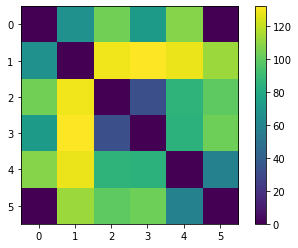

In [14]:
plt.imshow(dist)
plt.colorbar()

# III. Graph generation and plotting

In [15]:
# Create graph object
g = ig.Graph.Weighted_Adjacency(W,mode='undirected',attr='distance',loops=False)

## III.1 Node metadata

In [16]:
# Assigns a cluster value based on connected subgraphs. Useful for spring weight
g.vs['cluster'] = DF.loc[:,'group_'+seq_col]
g.vs['freq'] = DF.loc[:,'freq_'+seq_col]

### III.1.1 Node color
Define the fields `plot_label`, which will be the label in the legend of the plot, and `color` for each node. Depending on the type of label, the colouring and the labels will be different.

In [17]:
if custom_color:
    label2RGB = {}
    with open(custom_color) as file:
        for line in file:
            (key, value) = line.strip().split(',')
            if key in DF.loc[:,color_col].astype(str).values:
                label2RGB[int(key)] = tuple(v/255 for v in getcolor(value,'RGB'))
    n_colors = len(label2RGB)
    g.vs['color'] = DF.loc[:,color_col].map(label2RGB.get).values
elif color_col:
    color_label = DF.loc[:,color_col].values
    ## COLOR PALETTE ##
    # Define unique group labels
    _, idx = np.unique(color_label,return_index=True)
    labs = color_label[np.sort(idx)]
    n_colors = len(labs)
    # Create color pallete based on number of groups
    pal = ig.drawing.colors.ClusterColoringPalette(n_colors)
    label2RGB = {l:pal.get_many(c)[0] for c,l in enumerate(np.sort(labs))} # Numbering each label
    g.vs['color'] = [label2RGB[l] for l in color_label]
else:
    n_colors = 0

In [18]:
label2RGB

{'274-1': (1.0, 0.0, 0.0, 1.0),
 '274-2': (0.0, 1.0, 0.0, 1.0),
 '274-3': (0.0, 0.0, 1.0, 1.0)}

In [19]:
g.get_vertex_dataframe()

,cluster,freq,color
vertex ID,,,
0,0,1,"(0.0, 0.0, 1.0, 1.0)"
1,0,1,"(0.0, 0.0, 1.0, 1.0)"
2,0,1,"(0.0, 1.0, 0.0, 1.0)"
3,0,1,"(0.0, 1.0, 0.0, 1.0)"
4,0,1,"(1.0, 0.0, 0.0, 1.0)"
5,0,1,"(1.0, 0.0, 0.0, 1.0)"


### III.1.2 Node shape

In [20]:
if shape_col == None:
    g.vs['shape'] = 'circle'
    n_shapes = 0
else:
    shapes = ['circle','rectangle','triangle-up','triangle-down','diamond']
    funcs = [draw_circle,draw_square,draw_triangle_up,draw_triangle_down,draw_diamond]
    shape_labels = DF[shape_col].unique()
    n_shapes = len(shape_labels)
    if n_shapes > 5:
        raise ValueError('There can not be more than 5 shapes.')
    else:
        shapes = shapes[:n_shapes]
        shape_dic = {shape_labels[i]:shapes[i] for i in range(n_shapes)}
    g.vs['shape'] = DF.loc[:,shape_col].replace(shape_dic)

### III.1.3 Node size

In [21]:
if size_col==None:
    S = 1.5*unit
else:
    S = DF[size_col].values
    S = (S-np.min(S))/(np.max(S)-np.min(S))*(max_node_size-min_node_size)+min_node_size
g.vs['size'] = S

## III.2 Edge metadata

In [ ]:
g.es['color'] = ["black" if (edge['distance']>0.1 ) else "red" for edge in g.es]

In [23]:
g.get_edge_dataframe()

,source,target,distance,color
edge ID,,,,
0,0,5,0.1,white


### Graph layout
Creates a layout with the algorithm given by the keyword `layout_name` 

In [24]:
# Initialize layout with a seed (reproducibility)
random.seed(42)
np.random.seed(42)
layout_seed = np.random.random([len(g.vs),2])

# ToDo: Implement MDS and LgL

In [25]:
# Reingold-Fruchterman
if layout_name == 'FR':
    niter = 5000
    weights = kxs.prop_log_weights(g)
    g.es['weights'] = weights
    l = g.layout_fruchterman_reingold(weights=weights,\
                                      seed=layout_seed,niter=niter)
# Davidson-Harel
elif layout_name == 'DH':
    maxiter = 80
    fineiter = 15
    cool_fact = 0.95
    weight_node_dist = 1000
    weight_border = 20000000
    weight_edge_lengths = 0.1
    weight_edge_crossings = 1000
    weight_node_edge_dist = 10000
    l = g.layout_davidson_harel(seed=layout_seed, maxiter=maxiter, fineiter=fineiter,\
                                       cool_fact=cool_fact, weight_node_dist=weight_node_dist,\
                                       weight_border=weight_border,\
                                       weight_edge_lengths=weight_edge_lengths,\
                                       weight_edge_crossings=weight_edge_crossings,\
                                       weight_node_edge_dist=weight_node_edge_dist)
# Graphopt
elif layout_name == 'GO':
    niter = 500
    node_charge = 0.03
    node_mass = 5
    spring_length = 5
    spring_constant = 0.5
    max_sa_movement = 12
    l = g.layout_graphopt(niter=niter, node_charge=node_charge, node_mass=node_mass,\
                          spring_length=spring_length, spring_constant=spring_constant,\
                          max_sa_movement=max_sa_movement, seed=layout_seed)

In [26]:
g.get_vertex_dataframe()

,cluster,freq,color,shape,size
vertex ID,,,,,
0,0,1,"(0.0, 0.0, 1.0, 1.0)",circle,150.0
1,0,1,"(0.0, 0.0, 1.0, 1.0)",circle,150.0
2,0,1,"(0.0, 1.0, 0.0, 1.0)",circle,150.0
3,0,1,"(0.0, 1.0, 0.0, 1.0)",circle,150.0
4,0,1,"(1.0, 0.0, 0.0, 1.0)",circle,150.0
5,0,1,"(1.0, 0.0, 0.0, 1.0)",circle,150.0


#### Plot generation

In [27]:
# IV. Plot generation
if legend:
    label_h = 0.5*unit
    size = 0.25*unit
    width,height = (24*unit,18*unit)
    # Construct the plot
    plot = ig.Plot(out_file, bbox=(width,height), background="white")
    plot.add(g, bbox=(1*unit, 1*unit, width-7*unit, height-1*unit),layout=l,
             vertex_size=g.vs['size'])
    plot.redraw()
    ctx = cr.Context(plot.surface)
    # Legend rectangle
    n_labels = n_colors + bool(color_col)*1 + n_shapes + bool(shape_col)*1 + 3*bool(size_col)
    rect_height = label_h*(n_labels)
    rect_width = 3*unit # Change if the label is too long/short
    coord = (19*unit,9*unit-rect_height/2) # standing coordinates x,y
    ctx.rectangle(coord[0],coord[1], rect_width, rect_height)
    ctx.set_source_rgb(1, 1, 1)
    ctx.fill_preserve()
    ctx.set_source_rgb(0, 0, 0)
    ctx.set_line_width(2)
    ctx.stroke()
    # Legend items
    coord=(coord[0]+label_h,coord[1] + label_h)
    # Shape items
    if shape_col:
        for s in range(n_shapes):
            funcs[s](ctx,coord,size)
            coord = (coord[0] + 1.5*size,coord[1]+0.85*size)
            draw_text(ctx,str(shape_labels[s]),coord,size)
            coord = (coord[0]-1.5*size,coord[1]+1.15*size)
        coord = (coord[0],coord[1]+size)
    # Color items
#     if custom_color:
#         for k,v in val2col.items():
#             #RGB = getcolor(v, "RGB")
#             draw_circle(ctx,coord,size,in_color=(v[0],v[1],v[2]),
#                        line_color=(v[0],v[1],v[2]))
#             coord = (coord[0]+1.5*size,coord[1]+0.85*size)
#             draw_text(ctx,str(k),coord,size)
#             coord = (coord[0]-1.5*size,coord[1]+1.15*size)
#         coord = (coord[0],coord[1]+size)
    if color_col:
        for l,v in label2RGB.items():
            draw_circle(ctx,coord,size,in_color=(v[0],v[1],v[2]),
                       line_color=(v[0],v[1],v[2]))
            coord = (coord[0]+1.5*size,coord[1]+0.85*size)
            draw_text(ctx,str(l),coord,size)
            coord = (coord[0]-1.5*size,coord[1]+1.15*size)
        coord = (coord[0],coord[1]+size)
    # Size items
    if size_col:
        coord= (coord[0]+0.25*size,coord[1]+0.25*size)
        draw_circle(ctx,coord,min_node_size)
        coord = (coord[0]+4.5*size,coord[1]+0.6*size)
        draw_text(ctx,str(DF[size_col].min()),coord,size)
        
        coord = (coord[0]-6.25*size,coord[1]+1.15*size)
        draw_circle(ctx,coord,max_node_size,line_width = 0.05*size)
        coord = (coord[0]+3*label_h,coord[1]+label_h)
        draw_text(ctx,str(DF[size_col].max()),coord,size)
    # Save the plot
    plot.save()
else:
    visual_style = {
        'bbox' : (0, 0, 600, 600),
        'layout' : l,
        "margin": 20,
        "autocurve" : False
        #'edge_width' : g.es['width'],
    }
    ig.plot(g,target=out_file,**visual_style)